### Imports

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

from sklearn.metrics import r2_score

###############################################################################
# Lasso and Linear
from sklearn.linear_model import Lasso,LinearRegression
from sklearn.metrics import mean_squared_error

import scipy.optimize as sciop

In [6]:
!make fortran

clear
f2py -c -m irreverisble irreverisble.f90
running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "irreverisble" sources
f2py options: []
f2py:> /tmp/tmpH3eWMl/src.linux-x86_64-2.7/irreverisblemodule.c
creating /tmp/tmpH3eWMl/src.linux-x86_64-2.7
Reading fortran codes...
	Reading file 'irreverisble.f90' (format:free)
Post-processing...
	Block: irreverisble
			Block: mechanics
In: :irreverisble:irreverisble.f90:mechanics
get_parameters: got "name 'acos' is not defined" on 'acos(-1.0e0)'
Post-processing (stage 2)...
Building modules...
	Building module "irreverisble"...
		Constructing wrapper function "mechanics"...
		  stress_strain,wtn = mechanics(p_stress,ss_stress,tsam,m_para,[samples])
	Wrote C/API module "irreverisble" to file "/tmp/tmpH3eWMl/src.linux-x86_64-2.7/irrever

In [8]:
import irreverisble #importing the fortran mechanics routine

In [9]:
global exp
exp = []                           # ***** target 
exp = np.loadtxt('ref/HSRS/22')

In [5]:
# conveniently creates a plot with the attributes given
def plotSingle2D(comp,xtitle,ytitle,xscale,yscale):

        fig, ax = plt.subplots(figsize=(9,6))

        ax.plot(comp[:,0],comp[:,1],lw=3)
        ax.plot(exp[:,0], exp[:,1],'o',zorder=5,markevery=5)

        ax.set_xlabel(xtitle, fontsize=35, labelpad=15)
        ax.set_ylabel(ytitle, fontsize=35, labelpad=15)
        ax.tick_params(axis='x', labelsize=25, pad = 10)
        ax.tick_params(axis='y', labelsize=25, pad = 10)

        # we maintain only positive x&y values
        ax.set_xscale(xscale, nonposx='clip')
        ax.set_yscale(yscale, nonposx='clip')
        
        ax.set_xlim(0,exp[-1,0]+1) # margin
        ax.grid(True)
        fig.tight_layout()
        plt.show()

In [10]:
# --------------- material properties
T_service = 22. + 273.
prec_stress = 0
SS_stress = 750

# -------------- number samples, =1 in this case
no_samples = 1
# ============================== objective
# optimize these two parameters (model_parameters)
# to minimize the error between [exp] and [stress_strain]
# ==============================
model_parameters = (-100, 1)


# the function, irreverisble.mechanics, is used to calculate the stress-strain curve in plastic deforamtion region 
# the outputs are 2D list (stress-strain, stress_strain) and 1 parameter (work to necking, WTN)
strain_stress, WTN = irreverisble.mechanics(prec_stress,SS_stress,T_service,model_parameters,no_samples)
strain_stress = np.array(np.trim_zeros(strain_stress)).reshape(-1,2)

#necking_loc = strain_stress[strain_stress==WTN]
#plotSingle2D(strain_stress,'strain','stress','linear','linear')

### Attempting to get a minimum just using Nelder-Mead

In [7]:
def error_evaluation_rms(errors):
    
    sum_of_squares = 0
    
    for error in errors:
        sum_of_squares = sum_of_squares + error**2
        
    return (sum_of_squares**(1./2.))

def mcfunc(model_parameters):
    T_service = 22. + 273.
    prec_stress = 0
    SS_stress = 750
    
    strain_stress, WTN = irreverisble.mechanics(prec_stress,SS_stress,T_service,model_parameters,no_samples)
    strain_stress = np.array(np.trim_zeros(strain_stress)).reshape(-1,2)
    #print strain_stress
    
    #----------------------------
    cal_val = []
    errors = []
    
    #traverses experimental data points
    for iexp, data in enumerate(exp[:,0]):
        
        #finding nearest neighbors that surround the data points, and using them to determine the error
        for ical, data in enumerate(strain_stress[:,0]):
            
            ical = ical-1 # May or may not be advantageous to keep this instead of the range attribute for mem save
            
            left_strainpoint = strain_stress[ical,0]
            right_strainpoint = strain_stress[ical+1,0]
            
            exp_datapoint = exp[iexp,0]
            
            if(exp_datapoint>left_strainpoint and exp_datapoint<right_strainpoint):
                                
                # stores the differences between the successive approximations so we interpolate
                left_difference = exp_datapoint-left_strainpoint
                right_difference = right_strainpoint-exp_datapoint
                
                total_difference = left_difference+right_difference
                
                left_weight = left_difference/total_difference
                right_weight = right_difference/total_difference
                  
                # interpolate stress based on strain?
                interpolated_strain = left_weight*left_strainpoint + right_weight*right_strainpoint
                interpolated_stress = left_weight*strain_stress[ical,1] + right_weight*strain_stress[ical+1,1]
                    
                stress_error = interpolated_stress - exp[iexp,1]    
                #print stress_error
                
                #adds value, we want to find difference between these approximated data points and the real results
                cal_val.append([interpolated_strain,interpolated_stress])                 
                errors.append(stress_error)
                
                break
    
    #print errors
    error_rms = error_evaluation_rms(errors)    
    cal_val = np.asarray(cal_val)
    
    #print cal_val
    #----------------------------
    
    # return error as well as the results of stress-strain curve?
    return strain_stress, error_rms

strain_curve, error = mcfunc((-30, 0.823))

print error  

6375.47162714


In [8]:
#Two parameter system to optimize

%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plot

from scipy.optimize import minimize

import timeit
import resource

def error_evaluation_rms(errors):
    
    sum_of_squares = 0
    
    for error in errors:
        sum_of_squares = sum_of_squares + error**2
        
    return (sum_of_squares**(1./2.))

def mcfunc(model_parameters):
    T_service = 22. + 273.
    prec_stress = 0
    SS_stress = 750
    
    strain_stress, WTN = irreverisble.mechanics(prec_stress,SS_stress,T_service,model_parameters,no_samples)
    strain_stress = np.array(np.trim_zeros(strain_stress)).reshape(-1,2)
    #print strain_stress
    
    #----------------------------
    cal_val = []
    errors = []
    
    #traverses experimental data points
    for iexp, data in enumerate(exp[:,0]):
        
        #finding nearest neighbors that surround the data points, and using them to determine the error
        for ical, data in enumerate(strain_stress[:,0]):
            
            ical = ical-1 # May or may not be advantageous to keep this instead of the range attribute for mem save
            
            left_strainpoint = strain_stress[ical,0]
            right_strainpoint = strain_stress[ical+1,0]
            
            exp_datapoint = exp[iexp,0]
            
            if(exp_datapoint>left_strainpoint and exp_datapoint<right_strainpoint):
                                
                # stores the differences between the successive approximations so we interpolate
                left_difference = exp_datapoint-left_strainpoint
                right_difference = right_strainpoint-exp_datapoint
                
                total_difference = left_difference+right_difference
                
                left_weight = left_difference/total_difference
                right_weight = right_difference/total_difference
                  
                # interpolate stress based on strain?
                interpolated_strain = left_weight*left_strainpoint + right_weight*right_strainpoint
                interpolated_stress = left_weight*strain_stress[ical,1] + right_weight*strain_stress[ical+1,1]
                    
                stress_error = interpolated_stress - exp[iexp,1]    
                #print stress_error
                
                #adds value, we want to find difference between these approximated data points and the real results
                cal_val.append([interpolated_strain,interpolated_stress])                 
                errors.append(stress_error)
                
                break
    
    #print errors
    error_rms = error_evaluation_rms(errors)    
    cal_val = np.asarray(cal_val)
    
    #print cal_val
    #----------------------------
    
    # return error as well as the results of stress-strain curve?
    return error_rms


#all methods to minimize
methods = ['Nelder-Mead',]

start = np.zeros(0)
stop = np.zeros(0)
#num_iters = np.zeros(0)

all_mem = np.zeros(0)

#runtime code goes here

function = mcfunc

#testing every minimization method
for method in methods:
    
    start = np.append(start,timeit.default_timer())
    
    guess = [-500.,1.0]
    
    result = minimize(function, x0 = guess, method = method,tol=1e-6)
    mem = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss # cur mem in KB

    #num_iters = np.append(num_iters,result.nit)
    stop = np.append(stop,timeit.default_timer())
    
    # tracks amount of memory used
    all_mem = np.append(all_mem,mem/1000) 

exec_time = stop-start

for counter, method in enumerate(methods):
    
    print '{0} took {1} seconds. The result, {2} was found at {3}'.format(method,exec_time[counter],result.x,result.fun,)
    print '{0} used {1} megabytes'.format(method,all_mem[counter])
    print 

Nelder-Mead took 19.7307169437 seconds. The result, [ 172.25321272    2.19189234] was found at 5349.36463793
Nelder-Mead used 101.0 megabytes



In [9]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plot

from scipy.optimize import minimize

import timeit
from memory_profiler import memory_usage

#all methods to minimize
methods = ['Nelder-Mead','Powell','CG',]

start = np.zeros(0)
stop = np.zeros(0)
num_iters = np.zeros(0)

most_mem = np.zeros(0)

#runtime code goes here

function = mcfunc

#testing every minimization method
for method in methods:
    
    mem_use = memory_usage(-1,interval=0.1)
    start = np.append(start,timeit.default_timer())
    
    guess = [500,1] # guess for correct minimum
    
    # Possibly was finding the iterations in the wrong order
    result = minimize(function, x0 = guess, method = method,tol=1e-6)
    
    keys = result.keys() # contains all traits of result
    iterations = -1
    
    if 'nit' in keys:    
        iterations = result.get('nit')
        
    num_iters = np.append(num_iters,iterations)
    stop = np.append(stop,timeit.default_timer())
    
    # tracks amount of memory used
    most_mem = np.append(most_mem,max(mem_use)) 

exec_time = stop-start

# If an algorithm took (-1) iterations, the number of iterations was not returned
for counter, method in enumerate(methods):
    
    print '{0} took {1} seconds. The result, {4} was found at ({2}, {3})'.format(method,exec_time[counter],result.x[0],result.x[1],result.fun)
    print '{0} used {1} megabytes and took {2} iterations'.format(method,most_mem[counter],num_iters[counter])
    print
    

Nelder-Mead took 30.8250360489 seconds. The result, nan was found at (-87675516164.6, -45343755480.4)
Nelder-Mead used 99.8046875 megabytes and took 69.0 iterations

Powell took 7.46624088287 seconds. The result, nan was found at (-87675516164.6, -45343755480.4)
Powell used 99.82421875 megabytes and took 1.0 iterations

CG took 1.78442597389 seconds. The result, nan was found at (-87675516164.6, -45343755480.4)
CG used 99.8359375 megabytes and took 1.0 iterations



In [3]:
def error_evaluation_rms(errors):
    
    sum_of_squares = 0
    
    for error in errors:
        sum_of_squares = sum_of_squares + error**2
        
    return (sum_of_squares**(1./2.))

def mcfunc(model_parameters):
    T_service = 22. + 273.
    prec_stress = 0
    SS_stress = 750
    
    strain_stress, WTN = irreverisble.mechanics(prec_stress,SS_stress,T_service,model_parameters,no_samples)
    strain_stress = np.array(np.trim_zeros(strain_stress)).reshape(-1,2)
    #print strain_stress
    
    #----------------------------
    cal_val = []
    errors = []
    
    #traverses experimental data points
    for iexp, data in enumerate(exp[:,0]):
        
        #finding nearest neighbors that surround the data points, and using them to determine the error
        for ical, data in enumerate(strain_stress[:,0]):
            
            ical = ical-1 # May or may not be advantageous to keep this instead of the range attribute for mem save
            
            left_strainpoint = strain_stress[ical,0]
            right_strainpoint = strain_stress[ical+1,0]
            
            exp_datapoint = exp[iexp,0]
            
            if(exp_datapoint>left_strainpoint and exp_datapoint<right_strainpoint):
                                
                # stores the differences between the successive approximations so we interpolate
                left_difference = exp_datapoint-left_strainpoint
                right_difference = right_strainpoint-exp_datapoint
                
                total_difference = left_difference+right_difference
                
                left_weight = left_difference/total_difference
                right_weight = right_difference/total_difference
                  
                # interpolate stress based on strain?
                interpolated_strain = left_weight*left_strainpoint + right_weight*right_strainpoint
                interpolated_stress = left_weight*strain_stress[ical,1] + right_weight*strain_stress[ical+1,1]
                    
                stress_error = interpolated_stress - exp[iexp,1]    
                #print stress_error
                
                #adds value, we want to find difference between these approximated data points and the real results
                cal_val.append([interpolated_strain,interpolated_stress])                 
                errors.append(stress_error)
                
                break
    
    #print errors
    error_rms = error_evaluation_rms(errors)    
    cal_val = np.asarray(cal_val)
    
    #print cal_val
    #----------------------------
    
    # return error as well as the results of stress-strain curve?
    return error_rms


%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plot

from scipy.optimize import minimize

import timeit
from memory_profiler import memory_usage

#all methods to minimize
methods = []

start = np.zeros(0)
stop = np.zeros(0)
num_iters = np.zeros(0)

most_mem = np.zeros(0)

#runtime code goes here

function = mcfunc

#testing every minimization method
for method in methods:
    
    mem_use = memory_usage(-1,interval=0.1)
    start = np.append(start,timeit.default_timer())
    
    guess = [-500.,1.0] # guess for correct minimum
    
    # Possibly was finding the iterations in the wrong order
    result = minimize(function, x0 = guess, method = method,tol=1e-6)
    
    keys = result.keys() # contains all traits of result
    iterations = -1
    
    if 'nit' in keys:    
        iterations = result.get('nit')
        
    num_iters = np.append(num_iters,iterations)
    stop = np.append(stop,timeit.default_timer())
    
    # tracks amount of memory used
    most_mem = np.append(most_mem,max(mem_use)) 

exec_time = stop-start

# If an algorithm took (-1) iterations, the number of iterations was not returned
for counter, method in enumerate(methods):
    
    print '{0} took {1} seconds. The result, {4} was found at ({2}, {3})'.format(method,exec_time[counter],result.x[0],result.x[1],result.fun)
    print '{0} used {1} megabytes and took {2} iterations'.format(method,most_mem[counter],num_iters[counter])
    print
    

### Nelder Mead has been taking forever

In [11]:
def error_evaluation_rms(errors):
    
    sum_of_squares = 0
    
    for error in errors:
        sum_of_squares = sum_of_squares + error**2
        
    return (sum_of_squares**(1./2.))

def mcfunc(model_parameters):
    T_service = 22. + 273.
    prec_stress = 0
    SS_stress = 750
    
    strain_stress, WTN = irreverisble.mechanics(prec_stress,SS_stress,T_service,model_parameters,no_samples)
    strain_stress = np.array(np.trim_zeros(strain_stress)).reshape(-1,2)
    #print strain_stress
    
    #----------------------------
    cal_val = []
    errors = []
    
    #traverses experimental data points
    for iexp, data in enumerate(exp[:,0]):
        
        #finding nearest neighbors that surround the data points, and using them to determine the error
        for ical, data in enumerate(strain_stress[:,0]):
            
            ical = ical-1 # May or may not be advantageous to keep this instead of the range attribute for mem save
            
            left_strainpoint = strain_stress[ical,0]
            right_strainpoint = strain_stress[ical+1,0]
            
            exp_datapoint = exp[iexp,0]
            
            if(exp_datapoint>left_strainpoint and exp_datapoint<right_strainpoint):
                                
                # stores the differences between the successive approximations so we interpolate
                left_difference = exp_datapoint-left_strainpoint
                right_difference = right_strainpoint-exp_datapoint
                
                total_difference = left_difference+right_difference
                
                left_weight = left_difference/total_difference
                right_weight = right_difference/total_difference
                  
                # interpolate stress based on strain?
                interpolated_strain = left_weight*left_strainpoint + right_weight*right_strainpoint
                interpolated_stress = left_weight*strain_stress[ical,1] + right_weight*strain_stress[ical+1,1]
                    
                stress_error = interpolated_stress - exp[iexp,1]    
                #print stress_error
                
                #adds value, we want to find difference between these approximated data points and the real results
                cal_val.append([interpolated_strain,interpolated_stress])                 
                errors.append(stress_error)
                
                break
    
    #print errors
    error_rms = error_evaluation_rms(errors)    
    cal_val = np.asarray(cal_val)
    
    #print cal_val
    #----------------------------
    
    # return error as well as the results of stress-strain curve?
    return error_rms


%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plot

from scipy.optimize import minimize

import timeit
from memory_profiler import memory_usage

#all methods to minimize
methods = ['BFGS','L-BFGS-B','TNC','COBYLA','SLSQP',]

start = np.zeros(0)
stop = np.zeros(0)
num_iters = np.zeros(0)

most_mem = np.zeros(0)

#runtime code goes here

function = mcfunc

#testing every minimization method
for method in methods:
    
    mem_use = memory_usage(-1,interval=0.1)
    start = np.append(start,timeit.default_timer())
    
    guess = [-500.,1.0] # guess for correct minimum
    
    # Possibly was finding the iterations in the wrong order
    result = minimize(function, x0 = guess, method = method,tol=1e-6)
    
    keys = result.keys() # contains all traits of result
    iterations = -1
    
    if 'nit' in keys:    
        iterations = result.get('nit')
        
    num_iters = np.append(num_iters,iterations)
    stop = np.append(stop,timeit.default_timer())
    
    # tracks amount of memory used
    most_mem = np.append(most_mem,max(mem_use)) 

exec_time = stop-start

# If an algorithm took (-1) iterations, the number of iterations was not returned
for counter, method in enumerate(methods):
    
    print '{0} took {1} seconds. The result, {4} was found at ({2}, {3})'.format(method,exec_time[counter],result.x[0],result.x[1],result.fun)
    print '{0} used {1} megabytes and took {2} iterations'.format(method,most_mem[counter],num_iters[counter])
    print
    

BFGS took 74.8003568649 seconds. The result, nan was found at (nan, nan)
BFGS used 100.40234375 megabytes and took 7.0 iterations

L-BFGS-B took 22.2125439644 seconds. The result, nan was found at (nan, nan)
L-BFGS-B used 100.4765625 megabytes and took 5.0 iterations

TNC took 110.121945143 seconds. The result, nan was found at (nan, nan)
TNC used 100.703125 megabytes and took 5.0 iterations

COBYLA took 473.377817154 seconds. The result, nan was found at (nan, nan)
COBYLA used 100.703125 megabytes and took -1.0 iterations

SLSQP took 26.2444901466 seconds. The result, nan was found at (nan, nan)
SLSQP used 100.703125 megabytes and took 101.0 iterations



### We will need to visualize our data points to construct some prediction

### So far every result has been giving us strange answers that are inconsistent

In [12]:
#all methods to minimize
methods = ['SLSQP',]

start = np.zeros(0)
stop = np.zeros(0)
num_iters = np.zeros(0)

most_mem = np.zeros(0)


for method in methods:
    
    mem_use = memory_usage(-1,interval=0.1)
    start = np.append(start,timeit.default_timer())
    
    guess = [-500.,1.0] # guess for correct minimum
    
    # Possibly was finding the iterations in the wrong order
    result = minimize(function, x0 = guess, method = method,tol=1e-6)
    
    keys = result.keys() # contains all traits of result
    iterations = -1
    
    if 'nit' in keys:    
        iterations = result.get('nit')
        
    num_iters = np.append(num_iters,iterations)
    stop = np.append(stop,timeit.default_timer())
    
    # tracks amount of memory used
    most_mem = np.append(most_mem,max(mem_use)) 

exec_time = stop-start

# If an algorithm took (-1) iterations, the number of iterations was not returned
for counter, method in enumerate(methods):
    
    print '{0} took {1} seconds. The result, {4} was found at ({2}, {3})'.format(method,exec_time[counter],result.x[0],result.x[1],result.fun)
    print '{0} used {1} megabytes and took {2} iterations'.format(method,most_mem[counter],num_iters[counter])
    print

SLSQP took 26.0426239967 seconds. The result, nan was found at (nan, nan)
SLSQP used 100.703125 megabytes and took 101.0 iterations



<IPython.core.display.Javascript object>


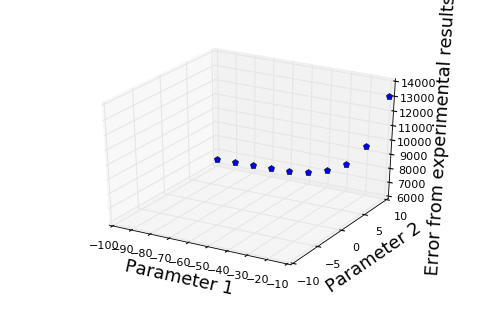

In [11]:
%matplotlib notebook 

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 14

fig = plt.figure()
ax = fig.gca(projection='3d')

interval = 10.

x_domain = np.arange(-100.,0.,interval)
y_domain = np.arange(-10.,20.,interval)

x = np.zeros(0)
y = np.zeros(0)

for y_val in y_domain:
    
    x = np.append(x,x_domain)
    
    for x_val in x_domain:
       
        y = np.append(y,y_val)

z = np.zeros(0)
        
for index, value in enumerate(x):
    
    model_params = (x[index],y[index])
    z = np.append(z,mcfunc(model_params))
    
ax.plot(x,y,z,"p")

ax.set_xlabel("Parameter 1", fontsize = 16)
ax.set_ylabel("Parameter 2", fontsize = 16)
ax.set_zlabel("Error from experimental results", fontsize = 16)

plt.show()

<IPython.core.display.Javascript object>


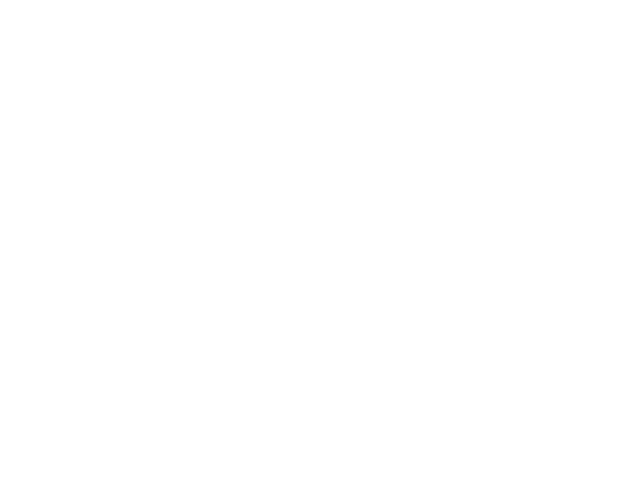

NameError: name 'mcfunc' is not defined

In [1]:
%matplotlib notebook 

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 14

fig = plt.figure()
ax = fig.gca(projection='3d')

interval = 600.

x_domain = np.arange(-20000.,-1.,interval) #expanded x domains
y_domain = np.arange(-1000.,1000.,interval)

x = np.zeros(0)
y = np.zeros(0)
z = np.zeros(0)

for y_val in y_domain:
    
    x = np.append(x,x_domain)
    
    for x_val in x_domain:
       
        y = np.append(y,y_val)

        
for index, value in enumerate(x):
    
    model_params = (x[index],y[index])
    z = np.append(z,mcfunc(model_params))
    
ax.plot(x,y,z,"ro")

ax.set_xlabel("Parameter 1", fontsize = 16)
ax.set_ylabel("Parameter 2", fontsize = 16)
ax.set_zlabel("Error from experimental results", fontsize = 14)

plt.show()

In [44]:
param_one = np.arange(-100.,0.,0.1)
param_two = np.zeros(len(param_one))

for index, value in enumerate(param_one):
    
    print mcfunc((param_one[index],param_two[index]))




nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [46]:
param_one = np.arange(-100.,0.,0.1)
param_two = np.zeros(len(param_one))


for index, value in enumerate(param_one):
    
    print mcfunc((param_one[index],param_two[index]))

error: failed in converting 4th argument `m_para' of irreverisble.mechanics to C/Fortran array

In [47]:
param_two = np.arange(-10.,10.,0.1)
param_one = np.full_like(param_two,-5.)


for index, value in enumerate(param_one):
    
    print mcfunc((param_one[index],param_two[index]))

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
7009.37091439
6764.7083005
15507.0237387
17071.0072867
17103.9328207
17104.5781203
17104.5907494
17104.5909966
17104.5910014
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015
17104.5910015

In [54]:
param_two = np.arange(-10.,10000.,100.)
param_one = np.full_like(param_two,-5.)


for index, value in enumerate(param_one):
    
    error = mcfunc((param_one[index],param_two[index]))
    if not math.isnan(error):
        print param_two[index], error

90.0 17104.5910015
190.0 17104.5910015
290.0 17104.5910015
390.0 17104.5910015
490.0 17104.5910015
590.0 17104.5910015
690.0 17104.5910015
790.0 17104.5910015
890.0 17104.5910015
990.0 17104.5910015
1090.0 17104.5910015


KeyboardInterrupt: 

In [57]:
param_two = np.arange(-10.,10000.,100.)
param_one = np.full_like(param_two,-10000.)


for index, value in enumerate(param_one):
    
    error = mcfunc((param_one[index],param_two[index]))
    if not math.isnan(error):
        print param_two[index], error

90.0 7006.60131156
190.0 7006.60131156
290.0 7006.60131156
390.0 7006.60131156
490.0 7006.60131156
590.0 7006.60131156
690.0 7006.60131156
790.0 7006.60131156
890.0 7006.60131156
990.0 7006.60131156
1090.0 7006.60131156
1190.0 7006.60131156
1290.0 7006.60131156
1390.0 7006.60131156
1490.0 7006.60131156
1590.0 7006.60131156
1690.0 7006.60131156
1790.0 7006.60131156
1890.0 7006.60131156
1990.0 7006.60131156
2090.0 7006.60131156
2190.0 7006.60131156
2290.0 7006.60131156
2390.0 7006.60131156
2490.0 7006.60131156
2590.0 7006.60131156
2690.0 7006.60131156
2790.0 7006.60131156
2890.0 7006.60131156
2990.0 7006.60131156
3090.0 7006.60131156
3190.0 7006.60131156
3290.0 7006.60131156
3390.0 7006.60131156
3490.0 7006.60131156
3590.0 7006.60131156
3690.0 7006.60131156
3790.0 7006.60131156
3890.0 7006.60131156
3990.0 7006.60131156
4090.0 7006.60131156
4190.0 7006.60131156
4290.0 7006.60131156
4390.0 7006.60131156
4490.0 7006.60131156
4590.0 7006.60131156
4690.0 7006.60131156
4790.0 7006.60131156
489

In [58]:
def error_evaluation_rms(errors):
    
    sum_of_squares = 0
    
    for error in errors:
        sum_of_squares = sum_of_squares + error**2
        
    return (sum_of_squares**(1./2.))

def mcfunc(model_parameters):
    T_service = 22. + 273.
    prec_stress = 0
    SS_stress = 750
    
    strain_stress, WTN = irreverisble.mechanics(prec_stress,SS_stress,T_service,model_parameters,no_samples)
    strain_stress = np.array(np.trim_zeros(strain_stress)).reshape(-1,2)
    #print strain_stress
    
    #----------------------------
    cal_val = []
    errors = []
    
    #traverses experimental data points
    for iexp, data in enumerate(exp[:,0]):
        
        #finding nearest neighbors that surround the data points, and using them to determine the error
        for ical, data in enumerate(strain_stress[:,0]):
            
            ical = ical-1 # May or may not be advantageous to keep this instead of the range attribute for mem save
            
            left_strainpoint = strain_stress[ical,0]
            right_strainpoint = strain_stress[ical+1,0]
            
            exp_datapoint = exp[iexp,0]
            
            if(exp_datapoint>left_strainpoint and exp_datapoint<right_strainpoint):
                                
                # stores the differences between the successive approximations so we interpolate
                left_difference = exp_datapoint-left_strainpoint
                right_difference = right_strainpoint-exp_datapoint
                
                total_difference = left_difference+right_difference
                
                left_weight = left_difference/total_difference
                right_weight = right_difference/total_difference
                  
                # interpolate stress based on strain?
                interpolated_strain = left_weight*left_strainpoint + right_weight*right_strainpoint
                interpolated_stress = left_weight*strain_stress[ical,1] + right_weight*strain_stress[ical+1,1]
                    
                stress_error = interpolated_stress - exp[iexp,1]    
                #print stress_error
                
                #adds value, we want to find difference between these approximated data points and the real results
                cal_val.append([interpolated_strain,interpolated_stress])                 
                errors.append(stress_error)
                
                break
    
    #print errors
    error_rms = error_evaluation_rms(errors)    
    cal_val = np.asarray(cal_val)
    
    #print cal_val
    #----------------------------
    
    # return error as well as the results of stress-strain curve?
    return error_rms


%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plot

from scipy.optimize import minimize

import timeit
from memory_profiler import memory_usage

#all methods to minimize
methods = ['COBYLA','SLSQP',]

start = np.zeros(0)
stop = np.zeros(0)
num_iters = np.zeros(0)

most_mem = np.zeros(0)

#runtime code goes here

function = mcfunc

#testing every minimization method
for method in methods:
    
    mem_use = memory_usage(-1,interval=0.1)
    start = np.append(start,timeit.default_timer())
    
    guess = [-500.,1.0] # guess for correct minimum
    
    # Possibly was finding the iterations in the wrong order
    result = minimize(function, x0 = guess, method = method,tol=1e-6)
    
    keys = result.keys() # contains all traits of result
    iterations = -1
    
    if 'nit' in keys:    
        iterations = result.get('nit')
        
    num_iters = np.append(num_iters,iterations)
    stop = np.append(stop,timeit.default_timer())
    
    # tracks amount of memory used
    most_mem = np.append(most_mem,max(mem_use)) 

exec_time = stop-start

# If an algorithm took (-1) iterations, the number of iterations was not returned
for counter, method in enumerate(methods):
    
    print '{0} took {1} seconds. The result, {4} was found at ({2}, {3})'.format(method,exec_time[counter],result.x[0],result.x[1],result.fun)
    print '{0} used {1} megabytes and took {2} iterations'.format(method,most_mem[counter],num_iters[counter])
    print
    

COBYLA took 464.452277899 seconds. The result, nan was found at (nan, nan)
COBYLA used 158.953125 megabytes and took -1.0 iterations

SLSQP took 26.6401939392 seconds. The result, nan was found at (nan, nan)
SLSQP used 158.953125 megabytes and took 101.0 iterations



In [61]:
def error_evaluation_rms(errors):
    
    sum_of_squares = 0
    
    for error in errors:
        sum_of_squares = sum_of_squares + error**2
        
    return (sum_of_squares**(1./2.))

def mcfunc(model_parameters):
    T_service = 22. + 273.
    prec_stress = 0
    SS_stress = 750
    
    strain_stress, WTN = irreverisble.mechanics(prec_stress,SS_stress,T_service,model_parameters,no_samples)
    strain_stress = np.array(np.trim_zeros(strain_stress)).reshape(-1,2)
    #print strain_stress
    
    #----------------------------
    cal_val = []
    errors = []
    
    #traverses experimental data points
    for iexp, data in enumerate(exp[:,0]):
        
        #finding nearest neighbors that surround the data points, and using them to determine the error
        for ical, data in enumerate(strain_stress[:,0]):
            
            ical = ical-1 # May or may not be advantageous to keep this instead of the range attribute for mem save
            
            left_strainpoint = strain_stress[ical,0]
            right_strainpoint = strain_stress[ical+1,0]
            
            exp_datapoint = exp[iexp,0]
            
            if(exp_datapoint>left_strainpoint and exp_datapoint<right_strainpoint):
                                
                # stores the differences between the successive approximations so we interpolate
                left_difference = exp_datapoint-left_strainpoint
                right_difference = right_strainpoint-exp_datapoint
                
                total_difference = left_difference+right_difference
                
                left_weight = left_difference/total_difference
                right_weight = right_difference/total_difference
                  
                # interpolate stress based on strain?
                interpolated_strain = left_weight*left_strainpoint + right_weight*right_strainpoint
                interpolated_stress = left_weight*strain_stress[ical,1] + right_weight*strain_stress[ical+1,1]
                    
                stress_error = interpolated_stress - exp[iexp,1]    
                #print stress_error
                
                #adds value, we want to find difference between these approximated data points and the real results
                cal_val.append([interpolated_strain,interpolated_stress])                 
                errors.append(stress_error)
                
                break
    
    #print errors
    error_rms = error_evaluation_rms(errors)    
    cal_val = np.asarray(cal_val)
    
    #print cal_val
    #----------------------------
    
    # return error as well as the results of stress-strain curve?
    return error_rms


%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plot

from scipy.optimize import minimize

import timeit
from memory_profiler import memory_usage

#all methods to minimize
methods = ['SLSQP']

start = np.zeros(0)
stop = np.zeros(0)
num_iters = np.zeros(0)

most_mem = np.zeros(0)

#runtime code goes here

function = mcfunc

#testing every minimization method
for method in methods:
    
    mem_use = memory_usage(-1,interval=0.1)
    start = np.append(start,timeit.default_timer())
    
    guess = [-5.,10.] # guess for correct minimum
    
    # Possibly was finding the iterations in the wrong order
    result = minimize(function, x0 = guess, method = method,tol=1e-6)
    
    keys = result.keys() # contains all traits of result
    iterations = -1
    
    if 'nit' in keys:    
        iterations = result.get('nit')
        
    num_iters = np.append(num_iters,iterations)
    stop = np.append(stop,timeit.default_timer())
    
    # tracks amount of memory used
    most_mem = np.append(most_mem,max(mem_use)) 

exec_time = stop-start

# If an algorithm took (-1) iterations, the number of iterations was not returned
for counter, method in enumerate(methods):
    
    print '{0} took {1} seconds. The result, {4} was found at ({2}, {3})'.format(method,exec_time[counter],result.x[0],result.x[1],result.fun)
    print '{0} used {1} megabytes and took {2} iterations'.format(method,most_mem[counter],num_iters[counter])
    print
    

SLSQP took 18.7804279327 seconds. The result, 6391.96616359 was found at (-97.2275121447, 10.0)
SLSQP used 158.953125 megabytes and took 9.0 iterations



In [89]:
"""
def error_evaluation_rms(errors):
    
    sum_of_squares = 0
    
    for error in errors:
        sum_of_squares = sum_of_squares + error**2
        
    return (sum_of_squares**(1./2.))

def mcfunc(model_parameters):
    T_service = 22. + 273.
    prec_stress = 0
    SS_stress = 750
    
    strain_stress, WTN = irreverisble.mechanics(prec_stress,SS_stress,T_service,model_parameters,no_samples)
    strain_stress = np.array(np.trim_zeros(strain_stress)).reshape(-1,2)
    #print strain_stress
    
    #----------------------------
    cal_val = []
    errors = []
    
    #traverses experimental data points
    for iexp, data in enumerate(exp[:,0]):
        
        #finding nearest neighbors that surround the data points, and using them to determine the error
        for ical, data in enumerate(strain_stress[:,0]):
            
            ical = ical-1 # May or may not be advantageous to keep this instead of the range attribute for mem save
            
            left_strainpoint = strain_stress[ical,0]
            right_strainpoint = strain_stress[ical+1,0]
            
            exp_datapoint = exp[iexp,0]
            
            if(exp_datapoint>left_strainpoint and exp_datapoint<right_strainpoint):
                                
                # stores the differences between the successive approximations so we interpolate
                left_difference = exp_datapoint-left_strainpoint
                right_difference = right_strainpoint-exp_datapoint
                
                total_difference = left_difference+right_difference
                
                left_weight = left_difference/total_difference
                right_weight = right_difference/total_difference
                  
                # interpolate stress based on strain?
                interpolated_strain = left_weight*left_strainpoint + right_weight*right_strainpoint
                interpolated_stress = left_weight*strain_stress[ical,1] + right_weight*strain_stress[ical+1,1]
                    
                stress_error = interpolated_stress - exp[iexp,1]    
                #print stress_error
                
                #adds value, we want to find difference between these approximated data points and the real results
                cal_val.append([interpolated_strain,interpolated_stress])                 
                errors.append(stress_error)
                
                break
    
    #print errors
    error_rms = error_evaluation_rms(errors)    
    cal_val = np.asarray(cal_val)
    
    #print cal_val
    #----------------------------
    
    # return error as well as the results of stress-strain curve?
    return error_rms


%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plot

from scipy.optimize import minimize

import timeit
from memory_profiler import memory_usage

#all methods to minimize
methods = ['SLSQP']

start = np.zeros(0)
stop = np.zeros(0)
num_iters = np.zeros(0)

most_mem = np.zeros(0)

#runtime code goes here

function = mcfunc

#testing every minimization method
for method in methods:
    
    mem_use = memory_usage(-1,interval=0.1)
    start = np.append(start,timeit.default_timer())
    
    guess = [-500.,100.] # guess for correct minimum
    
    # Possibly was finding the iterations in the wrong order
    result = minimize(function, x0 = guess, method = method,tol=1e-6)
    
    keys = result.keys() # contains all traits of result
    iterations = -1
    
    if 'nit' in keys:    
        iterations = result.get('nit')
        
    num_iters = np.append(num_iters,iterations)
    stop = np.append(stop,timeit.default_timer())
    
    # tracks amount of memory used
    most_mem = np.append(most_mem,max(mem_use)) 

exec_time = stop-start

# If an algorithm took (-1) iterations, the number of iterations was not returned
for counter, method in enumerate(methods):
    
    print '{0} took {1} seconds. The result, {4} was found at ({2}, {3})'.format(method,exec_time[counter],result.x[0],result.x[1],result.fun)
    print '{0} used {1} megabytes and took {2} iterations'.format(method,most_mem[counter],num_iters[counter])
    print
    """
    
print mcfunc((-97,1))

6391.95733757


In [90]:
def error_evaluation_rms(errors):
    
    sum_of_squares = 0
    
    for error in errors:
        sum_of_squares = sum_of_squares + error**2
        
    return (sum_of_squares**(1./2.))

def mcfunc(model_parameters):
    T_service = 22. + 273.
    prec_stress = 0
    SS_stress = 750
    
    strain_stress, WTN = irreverisble.mechanics(prec_stress,SS_stress,T_service,model_parameters,no_samples)
    strain_stress = np.array(np.trim_zeros(strain_stress)).reshape(-1,2)
    #print strain_stress
    
    #----------------------------
    cal_val = []
    errors = []
    
    #traverses experimental data points
    for iexp, data in enumerate(exp[:,0]):
        
        #finding nearest neighbors that surround the data points, and using them to determine the error
        for ical, data in enumerate(strain_stress[:,0]):
            
            ical = ical-1 # May or may not be advantageous to keep this instead of the range attribute for mem save
            
            left_strainpoint = strain_stress[ical,0]
            right_strainpoint = strain_stress[ical+1,0]
            
            exp_datapoint = exp[iexp,0]
            
            if(exp_datapoint>left_strainpoint and exp_datapoint<right_strainpoint):
                                
                # stores the differences between the successive approximations so we interpolate
                left_difference = exp_datapoint-left_strainpoint
                right_difference = right_strainpoint-exp_datapoint
                
                total_difference = left_difference+right_difference
                
                left_weight = left_difference/total_difference
                right_weight = right_difference/total_difference
                  
                # interpolate stress based on strain?
                interpolated_strain = left_weight*left_strainpoint + right_weight*right_strainpoint
                interpolated_stress = left_weight*strain_stress[ical,1] + right_weight*strain_stress[ical+1,1]
                    
                stress_error = interpolated_stress - exp[iexp,1]    
                #print stress_error
                
                #adds value, we want to find difference between these approximated data points and the real results
                cal_val.append([interpolated_strain,interpolated_stress])                 
                errors.append(stress_error)
                
                break
    
    #print errors
    error_rms = error_evaluation_rms(errors)    
    cal_val = np.asarray(cal_val)
    
    #print cal_val
    #----------------------------
    
    # return error as well as the results of stress-strain curve?
    return error_rms


%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plot

from scipy.optimize import minimize

import timeit
from memory_profiler import memory_usage

#all methods to minimize
methods = ['Powell']

start = np.zeros(0)
stop = np.zeros(0)
num_iters = np.zeros(0)

most_mem = np.zeros(0)

#runtime code goes here

function = mcfunc

#testing every minimization method
for method in methods:
    
    mem_use = memory_usage(-1,interval=0.1)
    start = np.append(start,timeit.default_timer())
    
    guess = [-5.,10.] # guess for correct minimum
    
    # Possibly was finding the iterations in the wrong order
    result = minimize(function, x0 = guess, method = method,tol=1e-6)
    
    keys = result.keys() # contains all traits of result
    iterations = -1
    
    if 'nit' in keys:    
        iterations = result.get('nit')
        
    num_iters = np.append(num_iters,iterations)
    stop = np.append(stop,timeit.default_timer())
    
    # tracks amount of memory used
    most_mem = np.append(most_mem,max(mem_use)) 

exec_time = stop-start

# If an algorithm took (-1) iterations, the number of iterations was not returned
for counter, method in enumerate(methods):
    
    print '{0} took {1} seconds. The result, {4} was found at ({2}, {3})'.format(method,exec_time[counter],result.x[0],result.x[1],result.fun)
    print '{0} used {1} megabytes and took {2} iterations'.format(method,most_mem[counter],num_iters[counter])
    print
    

Powell took 52.0896129608 seconds. The result, 4774.09130959 was found at (127.987565167, 37.8460355095)
Powell used 159.171875 megabytes and took 13.0 iterations



In [91]:
def error_evaluation_rms(errors):
    
    sum_of_squares = 0
    
    for error in errors:
        sum_of_squares = sum_of_squares + error**2
        
    return (sum_of_squares**(1./2.))

def mcfunc(model_parameters):
    T_service = 22. + 273.
    prec_stress = 0
    SS_stress = 750
    
    strain_stress, WTN = irreverisble.mechanics(prec_stress,SS_stress,T_service,model_parameters,no_samples)
    strain_stress = np.array(np.trim_zeros(strain_stress)).reshape(-1,2)
    #print strain_stress
    
    #----------------------------
    cal_val = []
    errors = []
    
    #traverses experimental data points
    for iexp, data in enumerate(exp[:,0]):
        
        #finding nearest neighbors that surround the data points, and using them to determine the error
        for ical, data in enumerate(strain_stress[:,0]):
            
            ical = ical-1 # May or may not be advantageous to keep this instead of the range attribute for mem save
            
            left_strainpoint = strain_stress[ical,0]
            right_strainpoint = strain_stress[ical+1,0]
            
            exp_datapoint = exp[iexp,0]
            
            if(exp_datapoint>left_strainpoint and exp_datapoint<right_strainpoint):
                                
                # stores the differences between the successive approximations so we interpolate
                left_difference = exp_datapoint-left_strainpoint
                right_difference = right_strainpoint-exp_datapoint
                
                total_difference = left_difference+right_difference
                
                left_weight = left_difference/total_difference
                right_weight = right_difference/total_difference
                  
                # interpolate stress based on strain?
                interpolated_strain = left_weight*left_strainpoint + right_weight*right_strainpoint
                interpolated_stress = left_weight*strain_stress[ical,1] + right_weight*strain_stress[ical+1,1]
                    
                stress_error = interpolated_stress - exp[iexp,1]    
                #print stress_error
                
                #adds value, we want to find difference between these approximated data points and the real results
                cal_val.append([interpolated_strain,interpolated_stress])                 
                errors.append(stress_error)
                
                break
    
    #print errors
    error_rms = error_evaluation_rms(errors)    
    cal_val = np.asarray(cal_val)
    
    #print cal_val
    #----------------------------
    
    # return error as well as the results of stress-strain curve?
    return error_rms


%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plot

from scipy.optimize import minimize

import timeit
from memory_profiler import memory_usage

#all methods to minimize
methods = ['BFGS','L-BFGS-B','TNC','COBYLA']

start = np.zeros(0)
stop = np.zeros(0)
num_iters = np.zeros(0)

most_mem = np.zeros(0)

#runtime code goes here

function = mcfunc

#testing every minimization method
for method in methods:
    
    mem_use = memory_usage(-1,interval=0.1)
    start = np.append(start,timeit.default_timer())
    
    guess = [-5.,10.] # guess for correct minimum
    
    # Possibly was finding the iterations in the wrong order
    result = minimize(function, x0 = guess, method = method,tol=1e-6)
    
    keys = result.keys() # contains all traits of result
    iterations = -1
    
    if 'nit' in keys:    
        iterations = result.get('nit')
        
    num_iters = np.append(num_iters,iterations)
    stop = np.append(stop,timeit.default_timer())
    
    # tracks amount of memory used
    most_mem = np.append(most_mem,max(mem_use)) 

exec_time = stop-start

# If an algorithm took (-1) iterations, the number of iterations was not returned
for counter, method in enumerate(methods):
    
    print '{0} took {1} seconds. The result, {4} was found at ({2}, {3})'.format(method,exec_time[counter],result.x[0],result.x[1],result.fun)
    print '{0} used {1} megabytes and took {2} iterations'.format(method,most_mem[counter],num_iters[counter])
    print
    

BFGS took 37.4627079964 seconds. The result, 6391.96616306 was found at (-97.2243199742, 10.6658423515)
BFGS used 159.171875 megabytes and took 2.0 iterations

L-BFGS-B took 20.6329731941 seconds. The result, 6391.96616306 was found at (-97.2243199742, 10.6658423515)
L-BFGS-B used 159.203125 megabytes and took 14.0 iterations

TNC took 71.7057409286 seconds. The result, 6391.96616306 was found at (-97.2243199742, 10.6658423515)
TNC used 159.203125 megabytes and took 7.0 iterations

COBYLA took 65.7748098373 seconds. The result, 6391.96616306 was found at (-97.2243199742, 10.6658423515)
COBYLA used 159.203125 megabytes and took -1.0 iterations



In [1]:
print mcfunc(-97.,1.)

NameError: name 'mcfunc' is not defined

### The parameters which minimize error are (-97.22432, 10.66584), but locally

### We can also try this with a different error function

In [93]:
# linear error function 
def error_evaluation_rms(errors):
    
    sum_errors = 0
    
    for error in errors:
        sum_errors = sum_errors + error
        
    return sum_errors

def mcfunc(model_parameters):
    T_service = 22. + 273.
    prec_stress = 0
    SS_stress = 750
    
    strain_stress, WTN = irreverisble.mechanics(prec_stress,SS_stress,T_service,model_parameters,no_samples)
    strain_stress = np.array(np.trim_zeros(strain_stress)).reshape(-1,2)
    #print strain_stress
    
    #----------------------------
    cal_val = []
    errors = []
    
    #traverses experimental data points
    for iexp, data in enumerate(exp[:,0]):
        
        #finding nearest neighbors that surround the data points, and using them to determine the error
        for ical, data in enumerate(strain_stress[:,0]):
            
            ical = ical-1 # May or may not be advantageous to keep this instead of the range attribute for mem save
            
            left_strainpoint = strain_stress[ical,0]
            right_strainpoint = strain_stress[ical+1,0]
            
            exp_datapoint = exp[iexp,0]
            
            if(exp_datapoint>left_strainpoint and exp_datapoint<right_strainpoint):
                                
                # stores the differences between the successive approximations so we interpolate
                left_difference = exp_datapoint-left_strainpoint
                right_difference = right_strainpoint-exp_datapoint
                
                total_difference = left_difference+right_difference
                
                left_weight = left_difference/total_difference
                right_weight = right_difference/total_difference
                  
                # interpolate stress based on strain?
                interpolated_strain = left_weight*left_strainpoint + right_weight*right_strainpoint
                interpolated_stress = left_weight*strain_stress[ical,1] + right_weight*strain_stress[ical+1,1]
                    
                stress_error = interpolated_stress - exp[iexp,1]    
                #print stress_error
                
                #adds value, we want to find difference between these approximated data points and the real results
                cal_val.append([interpolated_strain,interpolated_stress])                 
                errors.append(stress_error)
                
                break
    
    #print errors
    error_rms = error_evaluation_rms(errors)    
    cal_val = np.asarray(cal_val)
    
    #print cal_val
    #----------------------------
    
    # return error as well as the results of stress-strain curve?
    return error_rms


%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plot

from scipy.optimize import minimize

import timeit
from memory_profiler import memory_usage

#all methods to minimize
methods = ['BFGS','L-BFGS-B','TNC','COBYLA']

start = np.zeros(0)
stop = np.zeros(0)
num_iters = np.zeros(0)

most_mem = np.zeros(0)

#runtime code goes here

function = mcfunc

#testing every minimization method
for method in methods:
    
    mem_use = memory_usage(-1,interval=0.1)
    start = np.append(start,timeit.default_timer())
    
    guess = [-5.,10.] # guess for correct minimum
    
    # Possibly was finding the iterations in the wrong order
    result = minimize(function, x0 = guess, method = method,tol=1e-6)
    
    keys = result.keys() # contains all traits of result
    iterations = -1
    
    if 'nit' in keys:    
        iterations = result.get('nit')
        
    num_iters = np.append(num_iters,iterations)
    stop = np.append(stop,timeit.default_timer())
    
    # tracks amount of memory used
    most_mem = np.append(most_mem,max(mem_use)) 

exec_time = stop-start

# If an algorithm took (-1) iterations, the number of iterations was not returned
for counter, method in enumerate(methods):
    
    print '{0} took {1} seconds. The result, {4} was found at ({2}, {3})'.format(method,exec_time[counter],result.x[0],result.x[1],result.fun)
    print '{0} used {1} megabytes and took {2} iterations'.format(method,most_mem[counter],num_iters[counter])
    print
    

BFGS took 52.7310941219 seconds. The result, 23451.1946489 was found at (-999.943855946, 9.62641573377)
BFGS used 159.203125 megabytes and took 4.0 iterations

L-BFGS-B took 45.1663789749 seconds. The result, 23451.1946489 was found at (-999.943855946, 9.62641573377)
L-BFGS-B used 159.234375 megabytes and took 29.0 iterations

TNC took 46.439994812 seconds. The result, 23451.1946489 was found at (-999.943855946, 9.62641573377)
TNC used 159.234375 megabytes and took 5.0 iterations

COBYLA took 473.611748934 seconds. The result, 23451.1946489 was found at (-999.943855946, 9.62641573377)
COBYLA used 159.234375 megabytes and took -1.0 iterations



### Linear minimum is found at (-1000,9.626)

In [95]:
def error_evaluation_rms(errors):
    
    sum_of_squares = 0
    
    for error in errors:
        sum_of_squares = sum_of_squares + error**2
        
    return (sum_of_squares**(1./2.))

def mcfunc(model_parameters):
    T_service = 22. + 273.
    prec_stress = 0
    SS_stress = 750
    
    strain_stress, WTN = irreverisble.mechanics(prec_stress,SS_stress,T_service,model_parameters,no_samples)
    strain_stress = np.array(np.trim_zeros(strain_stress)).reshape(-1,2)
    #print strain_stress
    
    #----------------------------
    cal_val = []
    errors = []
    
    #traverses experimental data points
    for iexp, data in enumerate(exp[:,0]):
        
        #finding nearest neighbors that surround the data points, and using them to determine the error
        for ical, data in enumerate(strain_stress[:,0]):
            
            ical = ical-1 # May or may not be advantageous to keep this instead of the range attribute for mem save
            
            left_strainpoint = strain_stress[ical,0]
            right_strainpoint = strain_stress[ical+1,0]
            
            exp_datapoint = exp[iexp,0]
            
            if(exp_datapoint>left_strainpoint and exp_datapoint<right_strainpoint):
                                
                # stores the differences between the successive approximations so we interpolate
                left_difference = exp_datapoint-left_strainpoint
                right_difference = right_strainpoint-exp_datapoint
                
                total_difference = left_difference+right_difference
                
                left_weight = left_difference/total_difference
                right_weight = right_difference/total_difference
                  
                # interpolate stress based on strain?
                interpolated_strain = left_weight*left_strainpoint + right_weight*right_strainpoint
                interpolated_stress = left_weight*strain_stress[ical,1] + right_weight*strain_stress[ical+1,1]
                    
                stress_error = interpolated_stress - exp[iexp,1]    
                #print stress_error
                
                #adds value, we want to find difference between these approximated data points and the real results
                cal_val.append([interpolated_strain,interpolated_stress])                 
                errors.append(stress_error)
                
                break
    
    #print errors
    error_rms = error_evaluation_rms(errors)    
    cal_val = np.asarray(cal_val)
    
    #print cal_val
    #----------------------------
    
    # return error as well as the results of stress-strain curve?
    return error_rms


%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plot

from scipy.optimize import minimize

import timeit
from memory_profiler import memory_usage

#all methods to minimize
methods = ['Nelder-Mead','Powell','CG','BFGS','L-BFGS-B','TNC','COBYLA','SLSQP']

start = np.zeros(0)
stop = np.zeros(0)
num_iters = np.zeros(0)

most_mem = np.zeros(0)

#runtime code goes here

function = mcfunc

#testing every minimization method
for method in methods:
    
    mem_use = memory_usage(-1,interval=0.1)
    start = np.append(start,timeit.default_timer())
    
    guess = [-5.,10.] # guess for correct minimum
    
    # Possibly was finding the iterations in the wrong order
    result = minimize(function, x0 = guess, method = method,tol=1e-6)
    
    keys = result.keys() # contains all traits of result
    iterations = -1
    
    if 'nit' in keys:    
        iterations = result.get('nit')
        
    num_iters = np.append(num_iters,iterations)
    stop = np.append(stop,timeit.default_timer())
    
    # tracks amount of memory used
    most_mem = np.append(most_mem,max(mem_use)) 

exec_time = stop-start

# If an algorithm took (-1) iterations, the number of iterations was not returned
for counter, method in enumerate(methods):
    
    print '{0} took {1} seconds. The result, {4} was found at ({2}, {3})'.format(method,exec_time[counter],result.x[0],result.x[1],result.fun)
    print '{0} used {1} megabytes and took {2} iterations'.format(method,most_mem[counter],num_iters[counter])
    print
    

Nelder-Mead took 89.4426867962 seconds. The result, 6391.96616359 was found at (-97.2275121447, 10.0)
Nelder-Mead used 160.0 megabytes and took 101.0 iterations

Powell took 51.4126179218 seconds. The result, 6391.96616359 was found at (-97.2275121447, 10.0)
Powell used 160.32421875 megabytes and took 13.0 iterations

CG took 9.3399939537 seconds. The result, 6391.96616359 was found at (-97.2275121447, 10.0)
CG used 160.32421875 megabytes and took 1.0 iterations

BFGS took 37.6774799824 seconds. The result, 6391.96616359 was found at (-97.2275121447, 10.0)
BFGS used 160.32421875 megabytes and took 2.0 iterations

L-BFGS-B took 20.5767660141 seconds. The result, 6391.96616359 was found at (-97.2275121447, 10.0)
L-BFGS-B used 160.32421875 megabytes and took 14.0 iterations

TNC took 72.7374260426 seconds. The result, 6391.96616359 was found at (-97.2275121447, 10.0)
TNC used 160.32421875 megabytes and took 7.0 iterations

COBYLA took 66.1309537888 seconds. The result, 6391.96616359 was f

Nelder-Mead took 89.4426867962 seconds. The result, 6391.96616359 was found at (-97.2275121447, 10.0)
Nelder-Mead used 160.0 megabytes and took 101.0 iterations

Powell took 51.4126179218 seconds. The result, 6391.96616359 was found at (-97.2275121447, 10.0)
Powell used 160.32421875 megabytes and took 13.0 iterations

CG took 9.3399939537 seconds. The result, 6391.96616359 was found at (-97.2275121447, 10.0)
CG used 160.32421875 megabytes and took 1.0 iterations

BFGS took 37.6774799824 seconds. The result, 6391.96616359 was found at (-97.2275121447, 10.0)
BFGS used 160.32421875 megabytes and took 2.0 iterations

L-BFGS-B took 20.5767660141 seconds. The result, 6391.96616359 was found at (-97.2275121447, 10.0)
L-BFGS-B used 160.32421875 megabytes and took 14.0 iterations

TNC took 72.7374260426 seconds. The result, 6391.96616359 was found at (-97.2275121447, 10.0)
TNC used 160.32421875 megabytes and took 7.0 iterations

COBYLA took 66.1309537888 seconds. The result, 6391.96616359 was found at (-97.2275121447, 10.0)
COBYLA used 160.32421875 megabytes and took -1.0 iterations

SLSQP took 18.4281830788 seconds. The result, 6391.96616359 was found at (-97.2275121447, 10.0)
SLSQP used 160.32421875 megabytes and took 9.0 iterations 

(Results)